In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr,proc_mlrfcst,maria_IO
from tools.preprocess import do_eof,preproc_maria
import feature_select
from dask.distributed import Client
client = Client(processes=True, threads_per_worker=1,n_workers=2)
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/dask-worker-space/worker-aud3ydlj', purging
distributed.diskutils - INFO - Found stale lock file and directory '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/dask-worker-space/worker-13bdruie', purging
/tmp/ipykernel_3487255/2886357020.py:23: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


In [2]:
############################################################################################################################################
# PCA_dict: Processed EOF objects; A_dict: Variable anomaly matrices; Af_dict: Flattened variable anomaly matrices
# *note that following EOF conventions, we derived EOFs with anomalies.
############################################################################################################################################
# Basic settings
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/pca/output/uvwheat/'
expname = ['ctl','ncrf_36h','ncrf_60h','lwcrf']
varname = ['u','v','w']
nummem = [54,26,50,5,75,12,10]
#################################################################################
# 24-hr smoothing model
PCAdict = read_and_proc.depickle('./output/maria/processed/'+'PCA/PCAdict')
# Read files
flatvar = [read_and_proc.depickle(folderpath+'preproc/'+str(expname[i])+'_'+'smooth_preproc_dict1b_g') for i in range(len(expname))]
vardicts = maria_IO.input_output(PCAdict,folderpath,varname,nummem).readvar_separate(listdict=flatvar,varname=['u','v','w','qv','theta','hdia','rad'])
del flatvar#,thetavar
gc.collect()
#################################################################################
#duvwsen_dict = preproc_data('/scratch/08350/tg876493/ruppert2020/output/',['du','dv','dw']).senfile('/ctrlbase/','_CORR',True)

125

In [3]:
lti=24
models = read_and_proc.depickle('./output/maria/processed/FFW/'+str(lti)+'/FFWmodels_new')
newfeature = read_and_proc.depickle('./output/maria/processed/FFW/'+str(lti)+'/newfeature_new')
reducedX = read_and_proc.depickle('./output/maria/processed/FFW/'+str(lti)+'/reducedX_new')

In [4]:
import scipy
def azimuth2angle(azimuth=None):
    """
    https://math.stackexchange.com/questions/926226/conversion-from-azimuth-to-counterclockwise-angle
    """
    angletest = 450-azimuth
    for index,item in enumerate(angletest):
        if item>360:
            angletest[index] = item-360
        else:
            continue
    return angletest

def closest_index(array=None,target=None):
    return np.abs(array-target).argmin()

def polar2cartesian(outcoords, inputshape, origin):
    """Coordinate transform for converting a polar array to Cartesian coordinates. 
    inputshape is a tuple containing the shape of the polar array. origin is a
    tuple containing the x and y indices of where the origin should be in the
    output array."""
    
    xindex, yindex = outcoords
    x0, y0 = origin
    x = xindex - x0
    y = yindex - y0

    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    theta_index = np.round((theta + np.pi) * inputshape[1] / (2 * np.pi))
    return (r,theta_index)

def proc_tocart(polarfield=None,angle=None,twoD=True,standard=False):
    if twoD==True:
        PWnew = [np.asarray(polarfield)[int(np.abs(ANGLE-360).argmin()),:]]
        for i in np.linspace(0,358,359):
            PWnew.append(np.asarray(polarfield)[int(np.abs(ANGLE-i).argmin()),:])
        PWnew = np.swapaxes(np.asarray(PWnew),0,1)
        del i
        
        if standard==True:
            PWnew = (PWnew-np.nanmean(PWnew))/np.nanstd(PWnew)
        else:
            PWnew=PWnew

        test_2cartesian = scipy.ndimage.geometric_transform(PWnew, 
                                                            polar2cartesian,order=0,mode='constant',
                                                            output_shape = \
                                                            (PWnew.shape[0]*2,PWnew.shape[0]*2),
                                                            extra_keywords = \
                                                            {'inputshape':PWnew.shape,
                                                             'origin':(PWnew.shape[0],PWnew.shape[0])})
        #print('Finish processing')
        return ((test_2cartesian))

#### Feature Importance

In [5]:
def feature_importance_from_mlr(MODEL=None,smallX=None):
    def _get_feature_importance(WEIGHTx=None,smallXx=None):
        return np.nanmean(np.asarray([temp*smallXx for temp in WEIGHTx]),axis=1)
    weight = MODEL.coef_
    #WEIGHTZ = np.zeros_like(weight)
    return np.asarray([_get_feature_importance(weight[:,weightz],smallX[:,weightz]) for weightz in range(smallX.shape[1])])

In [6]:
ensemble_weights = [feature_importance_from_mlr(MODEL=models[i],smallX=reducedX[i]) for i in range(20)]

In [7]:
ensemble_weights[0].shape

(11, 205)

/tmp/ipykernel_3662207/3974497793.py:8: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


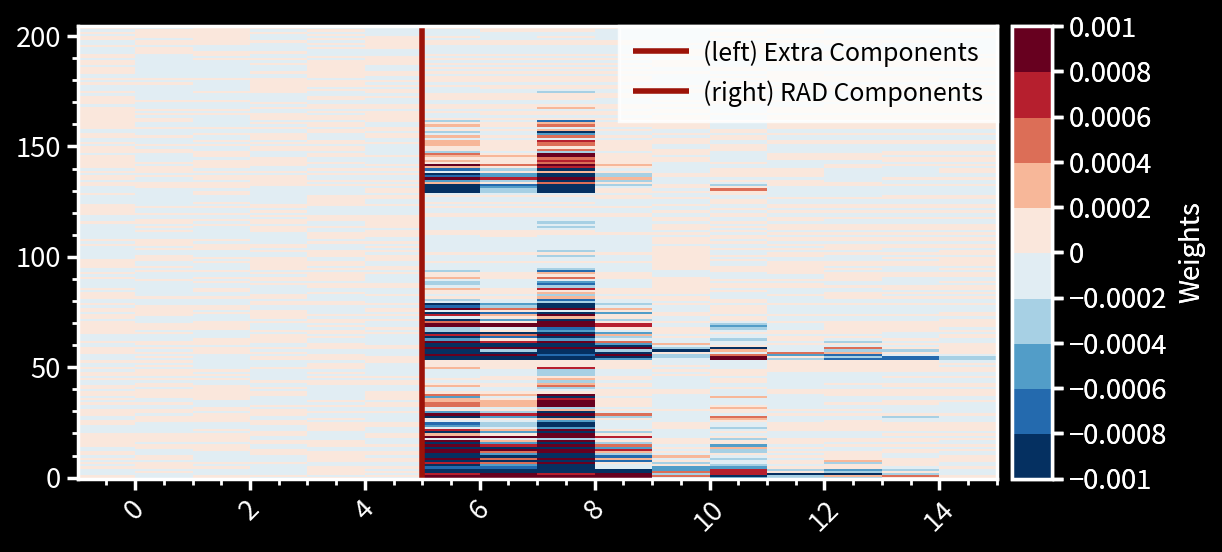

In [11]:
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.lines import Line2D
#for i in range(20):
i=5
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'

fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.595,refaspect=2.031)
l = axs[0].pcolormesh(np.linspace(0,10+i,11+i)-0.5,np.linspace(0,204,205),ensemble_weights[i].transpose(),cmap='BuRd',vmin=-0.001,vmax=0.001)
#axs.format(ylabel='Predictands',xticks=[-0.5,1-0.5,2-0.5,3-0.5,4-0.5,5-0.5,10+i],yticks=[25,69,132,179],yticklabels=['$\dot{u}$','$\dot{v}$','$\dot{w}$',r'$\dot{\theta}$'],\
#          xticklabels=['U8','U27','V22','LW5','LW8','LW12','RAD'],title=f'Model: RAD+{i+1}Extra')
#axs.format(ylabel='Predictands',xticks=[-0.5,10+i],yticks=[25,69,132,179],yticklabels=['$\dot{u}$','$\dot{v}$','$\dot{w}$',r'$\dot{\theta}$'],\
#          xticklabels=['LW12','RAD'],title=f'Model: RAD+{i+1}Extra')
l2 = axs[0].axvline(i,lw=2,color='#9c1309')
#for ix in [50,88,179]:
#    axs[0].axhline(ix,lw=0.5,color='k',ls='--')
custom_lines = [Line2D([0], [0], color='#9c1309', lw=2),Line2D([0], [0], color='#9c1309', lw=2)]
axs[0].legend(custom_lines, ['(left) Extra Components', '(right) RAD Components'],loc='ur',ncols=1,prop={'size':10})
plt.colorbar(l,ax=axs[0],label='Weights')
for tick in axs[0].get_xticklabels():
    tick.set_rotation(45)
#plt.savefig('../figures/0425//weights_'+str(i)+'.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

In [15]:
ANGLE = azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,167,168)*3),np.linspace(0,167,168)*3))

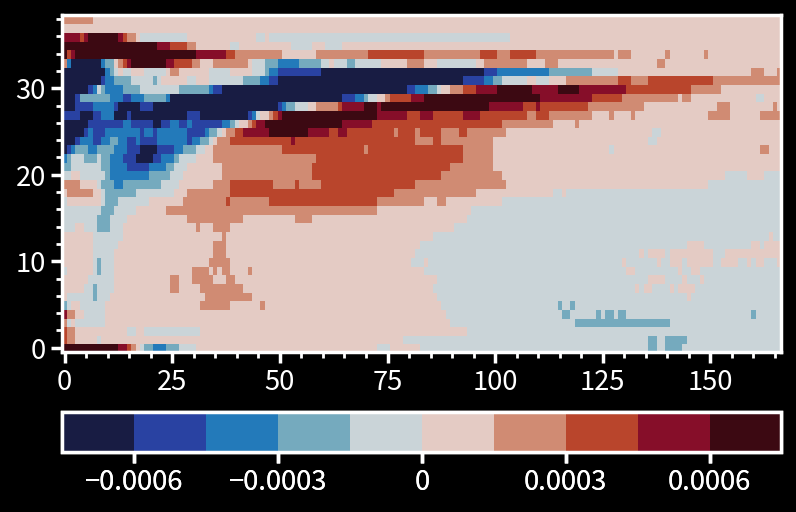

In [32]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.595,refaspect=2.131)
tw = axs[0].pcolormesh(np.mean(PCAdict['rad'].components_[5,:].reshape(39,360,167),axis=1),cmap='balance',vmin=-0.0008,vmax=0.0008)
axs[0].colorbar(tw,loc='b')
plt.show()

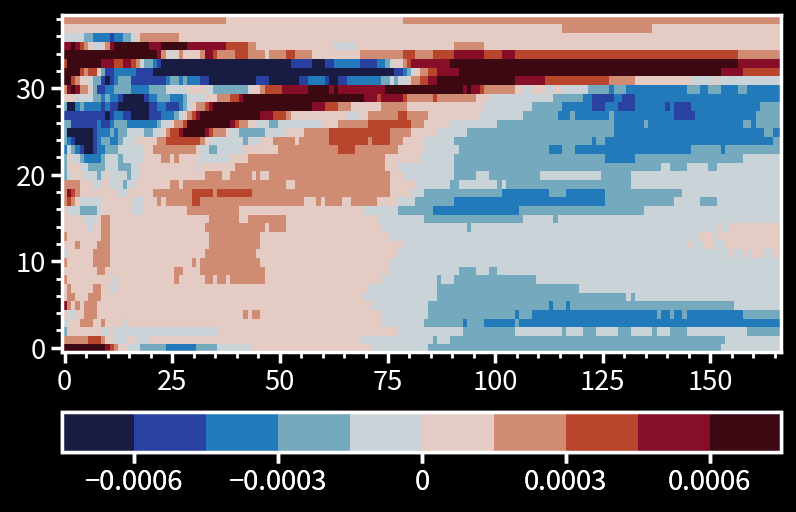

In [33]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.595,refaspect=2.131)
tw = axs[0].pcolormesh(np.mean(PCAdict['rad'].components_[8,:].reshape(39,360,167),axis=1),cmap='balance',vmin=-0.0008,vmax=0.0008)
axs[0].colorbar(tw,loc='b')
plt.show()

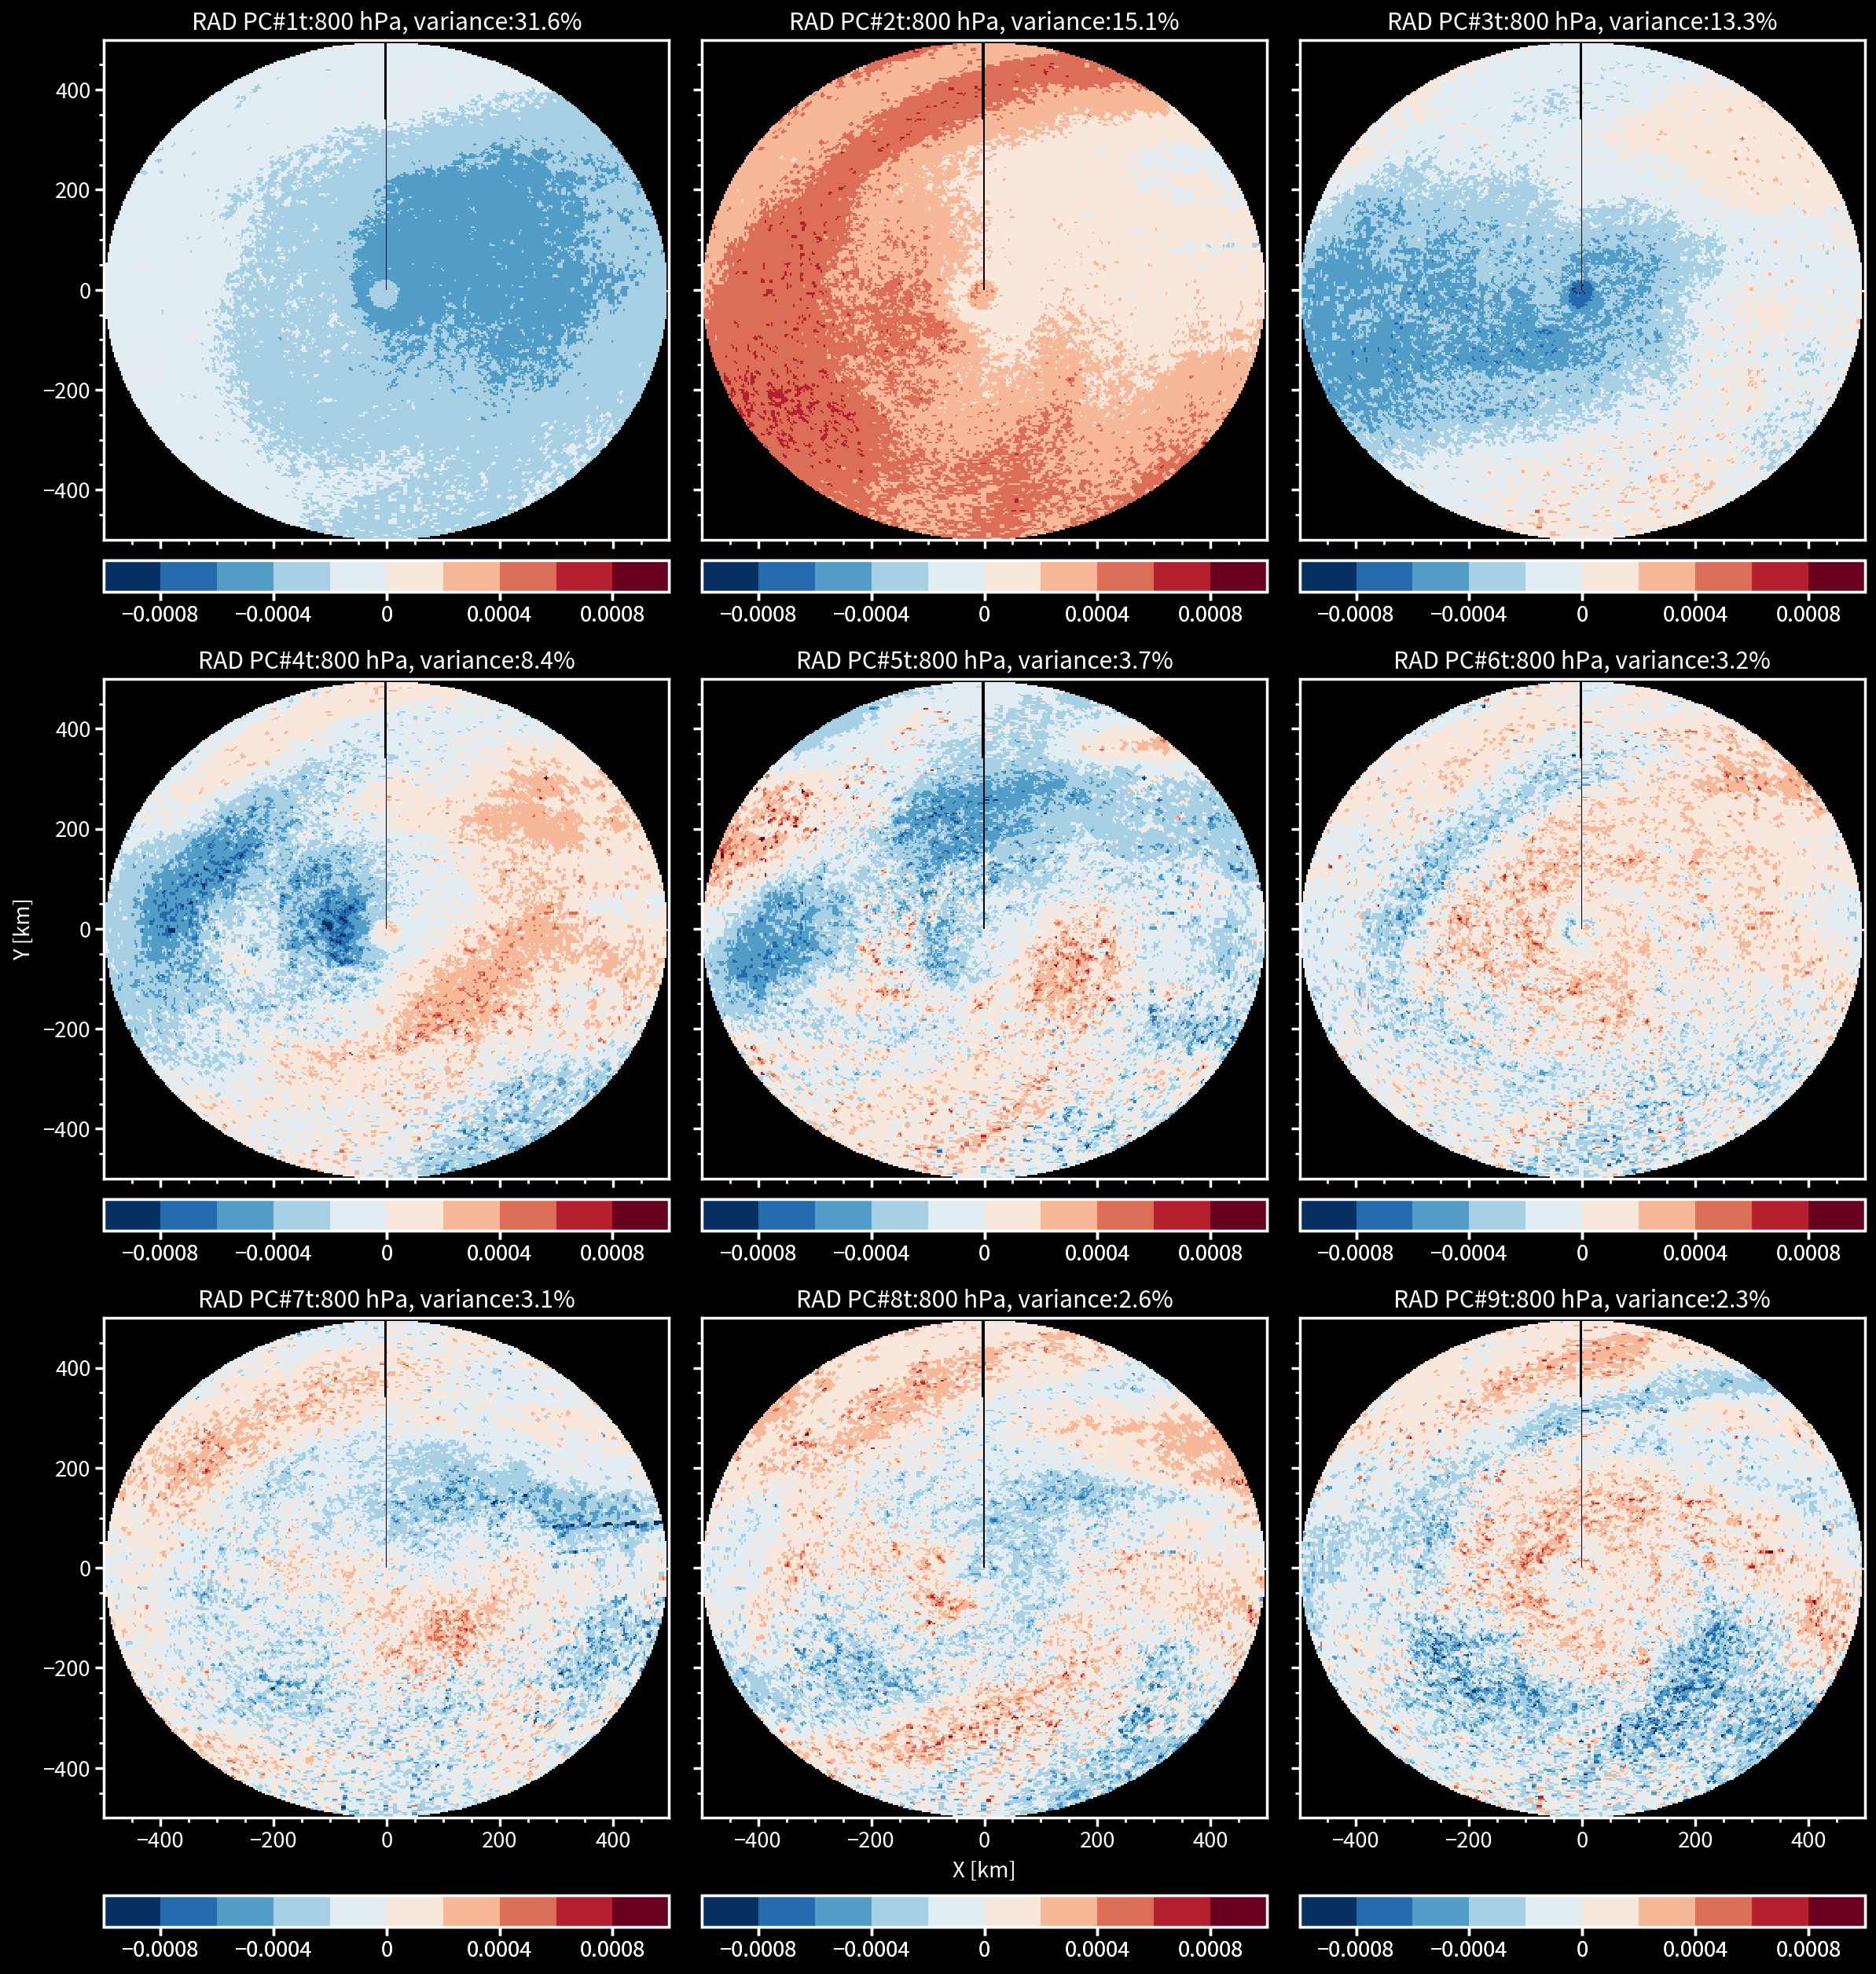

In [12]:
pcex = PCAdict['rad'].explained_variance_ratio_
fig,axs = plot.subplots(ncols=3,nrows=3,axwidth=3.595,refaspect=1.131)
for i in range(9):
    img=axs[i].pcolormesh(np.linspace(-166,166,334)*3,np.linspace(-166,166,334)*3,
                          np.ma.masked_equal(np.fliplr(np.flipud((proc_tocart(PCAdict['rad'].components_[i,:].reshape(39,360,167)[8,:,:],ANGLE,True,False)))),0),cmap='BuRd',vmin=-0.001,vmax=0.001) #vmin=-0.0005,vmax=0.0005
    axs[i].colorbar(img,loc='b')
    axs[i].format(ylabel='Y [km]',xlabel='X [km]',title=f'RAD PC#{i+1}t:{800} hPa, variance:{(pcex[i]*100):.1f}%')
#img=axs[1].pcolormesh(np.linspace(-207,207,417)*3,np.linspace(-207,207,417)*3,np.ma.masked_equal(np.fliplr(np.flipud((proc_tocart(TEST_rad6[2,:,:],ANGLE,True,False)))),0),cmap='BuRd',vmin=-0.0005,vmax=0.0005)
#axs[1].colorbar(img,loc='b')
#axs[1].format(ylabel='Y [km]',xlabel='X [km]',title=f'RAD 6th component:{800} hPa')
plt.savefig('./figures/0505/RADcomp_maria800.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

#### Predictions

In [5]:
def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
    
class retrieve_cartesian:
    def __init__(self,PCA_dict=None,Af_dict=None,numcomp=[11,11,15],LT=None,forecastPC=None,target='all',suffix=None):
        self.PCA_dict=PCA_dict
        self.numcomp=numcomp
        self.forecastPC = forecastPC
        self.LT = LT
        self.target=target
        self.suffix=suffix
        
    def get_time_diff_terms(self,inputvar=None,LT=None,wantvar=None):
        def _get_time_diff(array=None,timedelta=60*60,LT=None):
            store = []
            for exp in array:
                a = forward_diff(exp,timedelta,0,LT)
                if a.shape[0]>0:
                    azero = np.zeros((LT,exp.shape[-1]))
                    store.append(np.asarray(a))
                    #store.append(np.concatenate((a,azero),axis=0))
                else:
                    continue
                    #store.append(np.zeros((exp.shape[0],exp.shape[-1])))
            return store
        
        storedict = {}
        for wantvarZ,wantvarN in enumerate(wantvar):
            storedict[wantvarN] = _get_time_diff(array=inputvar[wantvarZ],LT=LT)
        return storedict
    
    def windrates_realMARIA(self,vardicts=None,LT=None):
        u = [vardicts[obj][0] for obj in ['ctl','ncrf_36h','ncrf_60h','lwcrf']]
        v = [vardicts[obj][1] for obj in ['ctl','ncrf_36h','ncrf_60h','lwcrf']]
        w = [vardicts[obj][2] for obj in ['ctl','ncrf_36h','ncrf_60h','lwcrf']]
        theta = [vardicts[obj][4] for obj in ['ctl','ncrf_36h','ncrf_60h','lwcrf']]
        
        dtermsT = self.get_time_diff_terms(inputvar=[u,v,w,theta],LT=LT,wantvar=['u','v','w','theta'])         
        
        #dudt = np.concatenate([testx for testx in dtermsT['u']],axis=0)
        #dvdt = np.concatenate([testx for testx in dtermsT['v']],axis=0)
        #dwdt = np.concatenate([testx for testx in dtermsT['w']],axis=0)
        #dthdt = np.concatenate([testx for testx in dtermsT['theta']],axis=0)
        #del dtermsT
        #gc.collect()
        return dtermsT
    
    def output_reshapeRECON(self,forecast_eig=None):
        if (self.target=='surface') or (self.target=='alluv'):
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            return testrec_dudt,testrec_dvdt
        else:
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            testrec_dwdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]:self.numcomp[0]+self.numcomp[1]+self.numcomp[2]],(self.PCA_dict['w'].components_[0:self.numcomp[2]]))#.reshape((39,360,167))
            testrec_dthdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]+self.numcomp[2]:],(self.PCA_dict['theta'].components_[0:self.numcomp[3]]))#.reshape((39,360,167))
            return testrec_dudt,testrec_dvdt,testrec_dwdt,testrec_dthdt
        
    def conversion_predictPC(self,yforecast=None,mshpe=[39,360,167]):
        if self.target=='surface':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return (t1.reshape(t1.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t1.shape[0],mshpe[1]*mshpe[2]),(t2.reshape(t2.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t2.shape[0],mshpe[1]*mshpe[2])
        elif self.target=='alluv':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2
        elif self.target=='all': 
            t1,t2,t3,t4 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2,t3,t4
        
    def output_r2(self,FFWmodels=None,reducedX=None,realU=None,realV=None,realW=None,realTH=None,case='Haiyan'):
        yf = [models.predict(Xns) for (models,Xns) in zip(FFWmodels[:],reducedX[:])]
        mlr_r2 = []
        for i in (range(45)):#len(yf))):
            if case=='Maria':
                temp1,temp2 = self.conversion_predictPC(yforecast=yf[i],mshpe=[39,360,167])
                mlr_r2.append(r2_score(np.concatenate((realU,realV),axis=0),np.concatenate((temp1,temp2),axis=0)))
            elif case=='Haiyan':
                try:
                    temp1,temp2 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,360,208])
                    a = r2_score(np.concatenate((realU,realV),axis=0),np.concatenate((temp1,temp2),axis=0))
                    print(a)
                    mlr_r2.append(a)
                except:
                    temp1,temp2,temp3,temp4 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,360,208])
                    a = r2_score(np.concatenate((realU,realV,realW,realTH),axis=0),np.concatenate((temp1,temp2,temp3,temp4),axis=0))
                    print(a)
                    mlr_r2.append(a)
            del temp1,temp2
            gc.collect()
        return mlr_r2

In [6]:
def replace_rad(reduced_X=None,alt_reducedX=None,numcomp=20,zeroout=True,extraterms=True):
    if zeroout:
        if extraterms:
            rad_only = reduced_X.copy()
            rad_only[:,-numcomp:] = 0
        else:
            rad_only = np.zeros_like(reduced_X)
            rad_only[:,-numcomp:] = reduced_X[:,-numcomp:]
            if alt_reducedX is not None:
                rad_only[:,-numcomp:] = alt_reducedX[:,-numcomp:]
    else:
        rad_only = reduced_X.copy()
        rad_only[:,-numcomp:] = alt_reducedX[:,-numcomp:]
    return rad_only

def replace_rad_oneterm(reduced_X=None,numcomp=20):
    rad_only = np.zeros_like(reduced_X)
    rad_only[:,-numcomp] = reduced_X[:,-numcomp]
    return rad_only

def prediction_to_cartesian(modelz=None,reducedX=None,alt_reducedX=None,shape=[10,360,208],target='alluv',task=None,replacerad=True,nummem=[50,38,91,8],radnum=20,singlenum=None):
    #nummem = [50,38,91,8]
    if target=='alluv':
        if task=='decomp':
            if replacerad: radonly = replace_rad(reducedX,alt_reducedX,numcomp=radnum,zeroout=True,extraterms=False)
            else: radonly = replace_rad(reducedX,None,numcomp=radnum,zeroout=True,extraterms=False)
            a,b = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(radonly),target=target,\
                               suffix=None).conversion_predictPC(modelz.predict(radonly)-modelz.intercept_,shape)
            return a,b
        elif task=='intercept':
            #a,b = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(np.zeros_like(reducedX)),target=target,\
            #                   suffix=None).conversion_predictPC(np.tile(modelz.intercept_,(reducedX.shape[0],1)),shape) #np.zeros_like(reducedX)
            a,b = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(np.zeros_like(reducedX)),target=target,\
                               suffix=None).conversion_predictPC(np.tile(modelz.intercept_,(reducedX.shape[0],1)),shape) #np.zeros_like(reducedX)
            return a,b
        elif task=='extraterms':
            radonly = replace_rad(reducedX,alt_reducedX,numcomp=radnum,zeroout=True,extraterms=True)
            a,b = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(np.zeros_like(reducedX)),target=target,\
                               suffix=None).conversion_predictPC(modelz.predict(radonly)-modelz.intercept_,shape)
            return a,b            
    elif target=='all':
        if task=='decomp':
            if replacerad: radonly = replace_rad(reducedX,alt_reducedX,numcomp=radnum,zeroout=True,extraterms=False)
            else: radonly = replace_rad(reducedX,None,numcomp=radnum,zeroout=True,extraterms=False)
            a,b,c,d = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(radonly),target=target,\
                               suffix=None).conversion_predictPC(modelz.predict(radonly)-modelz.intercept_,shape)
            return a,b,c,d
        elif task=='intercept':
            #a,b,c,d = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(np.zeros_like(reducedX)),target=target,\
            #                   suffix=None).conversion_predictPC(np.tile(modelz.intercept_,(reducedX.shape[0],1)),shape)
            a,b,c,d = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(np.zeros_like(reducedX)),target=target,\
                               suffix=None).conversion_predictPC(modelz.predict(np.zeros_like(reducedX)),shape)
            return a,b,c,d
        elif task=='extraterms':
            radonly = replace_rad(reducedX,alt_reducedX,numcomp=radnum,zeroout=True,extraterms=True)
            a,b,c,d = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(np.zeros_like(reducedX)),target=target,\
                               suffix=None).conversion_predictPC(modelz.predict(radonly)-modelz.intercept_,shape)
            return a,b,c,d
        elif task=='oneterm':
            radonly = replace_rad_oneterm(reducedX,singlenum)
            a,b,c,d = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=nummem,LT=lti,forecastPC=modelz.predict(radonly),target=target,\
                               suffix=None).conversion_predictPC(modelz.predict(radonly)-modelz.intercept_,shape)
            return a,b,c,d

##### Radiative

In [34]:
SWLWMEANdict.keys()

dict_keys(['LW', 'SW'])

In [7]:
# Radiative decomposition terms
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/maria/processed/'
SWLWdict = read_and_proc.depickle(folderpath+'radcomp/SWLW'+'_'+'dict_g')
LWCSWCIRdict = read_and_proc.depickle(folderpath+'radcomp/LWCSWCIR'+'_'+'dict_g')
SWLWMEANdict = read_and_proc.depickle(folderpath+'radcomp/SWLW_MEAN'+'_'+'dict_g')
LWCSWCIRMEANdict = read_and_proc.depickle(folderpath+'radcomp/LWCSWCIR_MEAN'+'_'+'dict_g')
# Original Input/Output
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/maria/processed/'
file2 = [path+'inputoutput/'+'inputQ95_dict_new_smoo6_withtheta',path+'inputoutput/'+'outputQ95_dict_new_smoo6_withtheta']#,path+'NOIR_dict_smoo6_withtheta',path+'IR_dict_smoo6_withtheta']
mlr_inputdict,mlr_output = read_and_proc.depickle(file2[0]),read_and_proc.depickle(file2[1])

In [8]:
def delete_padding(inTS=None,outTS=None):
    output_nozero,input_nozero = [],[]
    for i in range(len(outTS[:,0])):
        temp = outTS[i,:]
        tempin = inTS[i,:]
        if temp.all()==0:
            continue
        else:
            output_nozero.append(temp)
            input_nozero.append(tempin)
    return input_nozero,output_nozero

In [9]:
lti = 24
train_lw_proc,train_sw_proc = np.asarray(delete_padding(SWLWdict['LW'],mlr_output[int(lti)-1])[0]),np.asarray(delete_padding(SWLWdict['SW'],mlr_output[int(lti)-1])[0])
train_irlw_proc,train_irsw_proc = np.asarray(delete_padding(LWCSWCIRdict['IRLW'],mlr_output[int(lti)-1])[0]),np.asarray(delete_padding(LWCSWCIRdict['IRSW'],mlr_output[int(lti)-1])[0])
train_irlwm_proc,train_irswm_proc = np.asarray(delete_padding(LWCSWCIRMEANdict['IRLW'],mlr_output[int(lti)-1])[0]),np.asarray(delete_padding(LWCSWCIRMEANdict['IRSW'],mlr_output[int(lti)-1])[0])
train_lwc_proc,train_swc_proc = np.asarray(delete_padding(LWCSWCIRdict['LWC'],mlr_output[int(lti)-1])[0]),np.asarray(delete_padding(LWCSWCIRdict['SWC'],mlr_output[int(lti)-1])[0])

##### Separate contributions

In [10]:
# Full model
dudt_b,dvdt_b,dwdt_b,dthdt_b = prediction_to_cartesian(models[5],reducedX[5],None,[39,360,167],'all','intercept',False,[54,26,50,75],10)
dudt_rad,dvdt_rad,dwdt_rad,dthdt_rad = prediction_to_cartesian(models[5],reducedX[5],None,[39,360,167],'all','decomp',False,[54,26,50,75],10)
dudt_extra,dvdt_extra,dwdt_extra,dthdt_extra = prediction_to_cartesian(models[5],reducedX[5],None,[39,360,167],'all','extraterms',False,[54,26,50,75],10)
dudt_full,dvdt_full,dwdt_full,dthdt_full = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=[54,26,50,75],LT=lti,forecastPC=models[5].predict((reducedX[5])),target='all',\
                               suffix=None).conversion_predictPC(models[5].predict((reducedX[5])),[39,360,167])
# Decomposed Terms
dudt_irlw,dvdt_irlw,dwdt_irlw,dthdt_irlw = prediction_to_cartesian(models[5],reducedX[5],train_irlw_proc,[39,360,167],'all','decomp',True,[54,26,50,75],10)
dudt_irsw,dvdt_irsw,dwdt_irsw,dthdt_irsw = prediction_to_cartesian(models[5],reducedX[5],train_irsw_proc,[39,360,167],'all','decomp',True,[54,26,50,75],10)
dudt_lwc,dvdt_lwc,dwdt_lwc,dthdt_lwc = prediction_to_cartesian(models[5],reducedX[5],train_lwc_proc,[39,360,167],'all','decomp',True,[54,26,50,75],10)
dudt_swc,dvdt_swc,dwdt_swc,dthdt_swc = prediction_to_cartesian(models[5],reducedX[5],train_swc_proc,[39,360,167],'all','decomp',True,[54,26,50,75],10)

In [11]:
dudt_irlwm,dvdt_irlwm,dwdt_irlwm,dthdt_irlwm = prediction_to_cartesian(models[5],reducedX[5],train_irlwm_proc,[39,360,167],'all','decomp',True,[54,26,50,75],10)
dudt_irswm,dvdt_irswm,dwdt_irswm,dthdt_irswm = prediction_to_cartesian(models[5],reducedX[5],train_irswm_proc,[39,360,167],'all','decomp',True,[54,26,50,75],10)
dudt_lw,dvdt_lw,dwdt_lw,dthdt_lw = prediction_to_cartesian(models[5],reducedX[5],train_lw_proc,[39,360,167],'all','decomp',True,[54,26,50,75],10)
dudt_sw,dvdt_sw,dwdt_sw,dthdt_sw = prediction_to_cartesian(models[5],reducedX[5],train_sw_proc,[39,360,167],'all','decomp',True,[54,26,50,75],10)

In [52]:
dudt_rad6,dvdt_rad6,dwdt_rad6,dthdt_rad6 = prediction_to_cartesian(models[5],reducedX[5],train_irlw_proc,[39,360,167],'all','oneterm',True,[54,26,50,75],10,5)
dudt_rad9,dvdt_rad9,dwdt_rad9,dthdt_rad9 = prediction_to_cartesian(models[5],reducedX[5],train_irsw_proc,[39,360,167],'all','decomp',True,[54,26,50,75],10,2)

In [13]:
realMARIA = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=None,numcomp=[54,26,50,75],LT=lti,forecastPC=models[5].predict((reducedX[5])),target='all',\
                               suffix=None).windrates_realMARIA(vardicts=vardicts,LT=lti)

In [45]:
ANGLE = azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,167,168)*3),np.linspace(0,167,168)*3))

y_ctrl60 = [np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_full-dvdt_b).reshape(dvdt_full.shape[0],39,360,167))[10+12,0,...],ANGLE,True,False)))),
    np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_extra).reshape(dvdt_full.shape[0],39,360,167))[10+12,0,...],ANGLE,True,False)))),
        np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_rad).reshape(dvdt_full.shape[0],39,360,167))[10+12,0,...],ANGLE,True,False)))),
      np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_irlw).reshape(dvdt_full.shape[0],39,360,167))[10+12,0,...],ANGLE,True,False)))),
      np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_irsw).reshape(dvdt_full.shape[0],39,360,167))[10+12,0,...],ANGLE,True,False)))),
      np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_lwc).reshape(dvdt_full.shape[0],39,360,167))[10+12,0,...],ANGLE,True,False)))),
      np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_swc).reshape(dvdt_full.shape[0],39,360,167))[10+12,0,...],ANGLE,True,False))))]

y_ncrf60 = [np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_full-dvdt_b).reshape(dvdt_full.shape[0],39,360,167))[96+12,0,...],ANGLE,True,False)))),
    np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_extra).reshape(dvdt_full.shape[0],39,360,167))[96+12,0,...],ANGLE,True,False)))),
        np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_rad).reshape(dvdt_full.shape[0],39,360,167))[96+12,0,...],ANGLE,True,False)))),
      np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_irlw).reshape(dvdt_full.shape[0],39,360,167))[96+12,0,...],ANGLE,True,False)))),
      np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_irsw).reshape(dvdt_full.shape[0],39,360,167))[96+12,0,...],ANGLE,True,False)))),
      np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_lwc).reshape(dvdt_full.shape[0],39,360,167))[96+12,0,...],ANGLE,True,False)))),
      np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_swc).reshape(dvdt_full.shape[0],39,360,167))[96+12,0,...],ANGLE,True,False))))]

/tmp/ipykernel_3487255/1942119501.py:3: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 12,'linewidth':1.25})


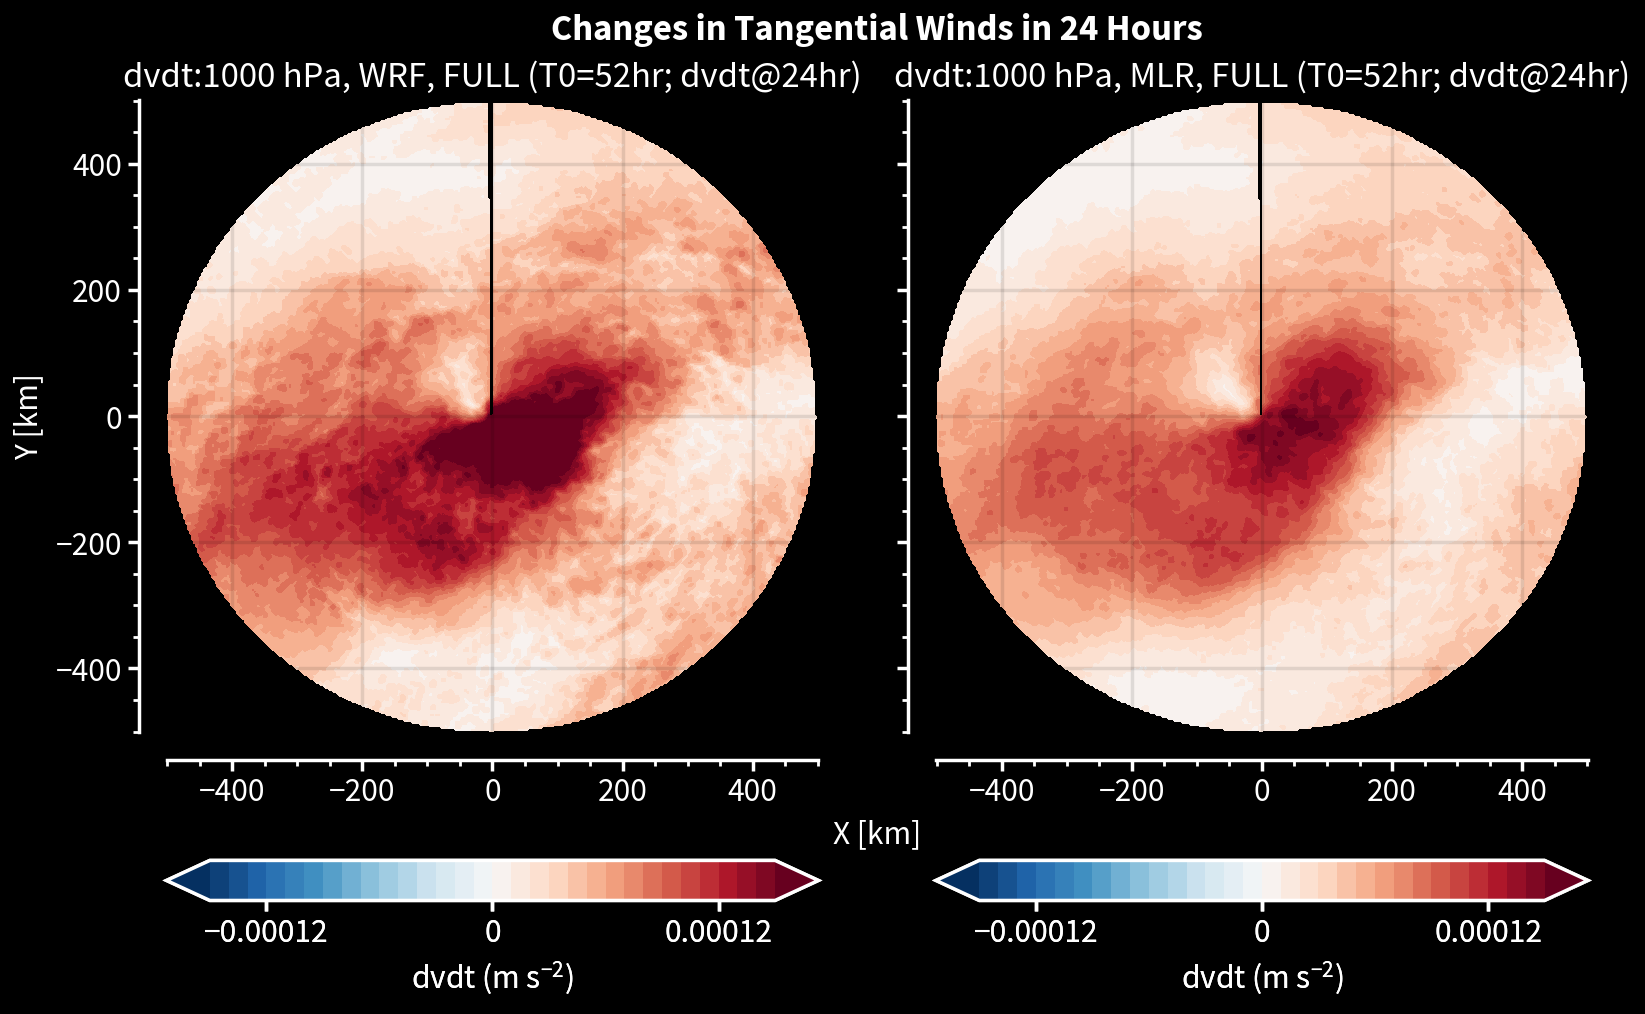

In [24]:
from tools import plotting
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 12,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'
ANGLE = azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,167,168)*3),np.linspace(0,167,168)*3))

smpl = 406
y = [ np.fliplr(np.flipud((read_and_proc.proc_tocart(realMARIA['v'][0][24+6,:].reshape(39,360,167)[0,...],ANGLE,True,False)))),\
     #np.fliplr(np.flipud((read_and_proc.proc_tocart(realMARIA['v'][1][24+6,:].reshape(39,360,167)[0,...],ANGLE,True,False)))),\
    np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_full).reshape(dvdt_full.shape[0],39,360,167))[10+14+6,0,...],ANGLE,True,False))))]
     #np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_full).reshape(dvdt_full.shape[0],39,360,167))[72+14+6,0,...],ANGLE,True,False))))]
yu = [ np.fliplr(np.flipud((read_and_proc.proc_tocart(realMARIA['u'][0][24+6,:].reshape(39,360,167)[0,...],ANGLE,True,False)))),\
     #np.fliplr(np.flipud((read_and_proc.proc_tocart(realMARIA['u'][1][24+6,:].reshape(39,360,167)[0,...],ANGLE,True,False)))),\
    np.fliplr(np.flipud((read_and_proc.proc_tocart(((dudt_full).reshape(dvdt_full.shape[0],39,360,167))[10+14+6,0,...],ANGLE,True,False))))]
     #np.fliplr(np.flipud((read_and_proc.proc_tocart(((dudt_full).reshape(dvdt_full.shape[0],39,360,167))[72+14+6,0,...],ANGLE,True,False))))]

#typelabel=['WRF, FULL (T0=52hr)','WRF, NCRF36 (T0=52hr)','MLR, FULL (T0=52hr)','MLR, NCRF36 (T0=52hr)']
typelabel=['WRF, FULL (T0=52hr; dvdt@24hr)','MLR, FULL (T0=52hr; dvdt@24hr)']
fig, axs = plot.subplots(ncols=2,nrows=1,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)',suptitle='Changes in Tangential Winds in 24 Hours')
for indices in range(2):
    axs[indices].contourf(np.linspace(-167,167,334)*3,np.linspace(-167,167,334)*3,np.ma.masked_equal(np.sqrt(y[indices]**2+yu[indices]**2),0),\
                            cmap='BuRd',levels=np.linspace(-15e-5,15e-5,31),colorbar='b',colorbar_kw={'format':'simple','ticks':0.00012,'label':'dvdt (m s$^{-2}$)'},extend='both')
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'dvdt:{1000} hPa, {typelabel[indices]}')
    plotting.adjust_spines(axs[indices],['left','bottom'],10)
#axs[7].set_visible(False)
plt.savefig('./figures/0505/maria_MLRpredict_52.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

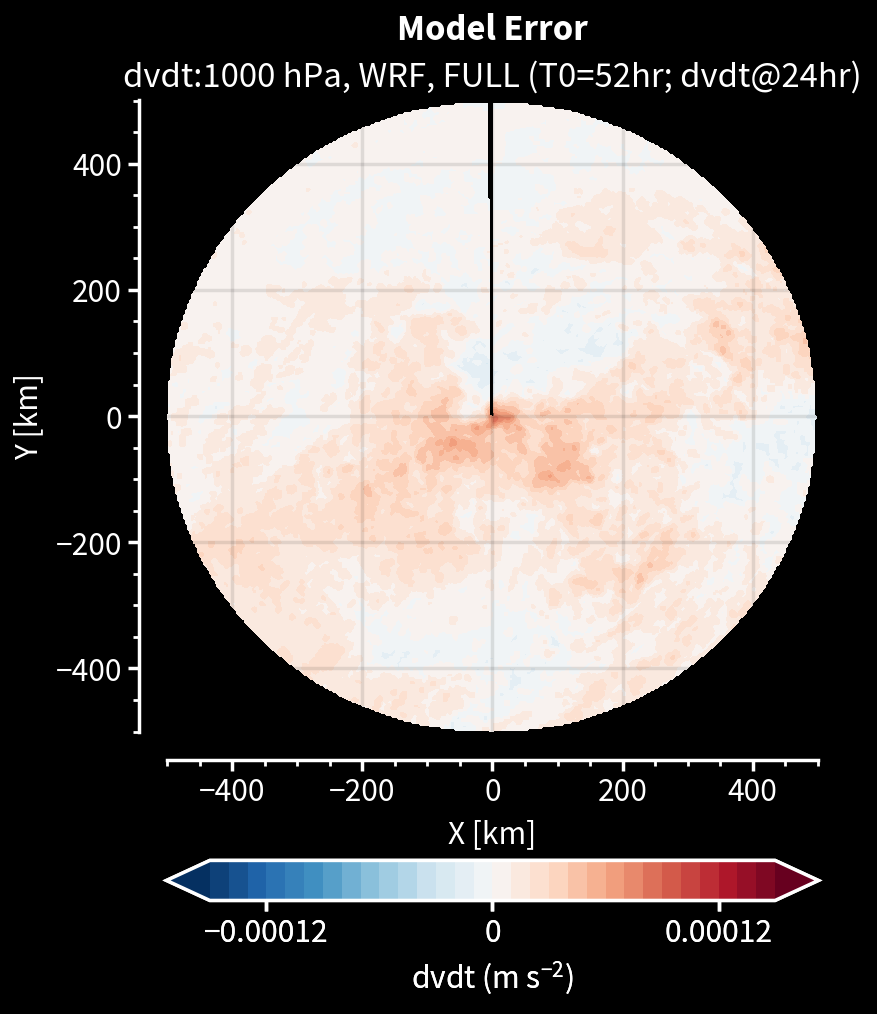

In [28]:
smpl = 406
y = [ np.fliplr(np.flipud((read_and_proc.proc_tocart(realMARIA['v'][0][24+6,:].reshape(39,360,167)[0,...],ANGLE,True,False)))),\
     #np.fliplr(np.flipud((read_and_proc.proc_tocart(realMARIA['v'][1][24+6,:].reshape(39,360,167)[0,...],ANGLE,True,False)))),\
    np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_full).reshape(dvdt_full.shape[0],39,360,167))[10+14+6,0,...],ANGLE,True,False))))]
     #np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_full).reshape(dvdt_full.shape[0],39,360,167))[72+14+6,0,...],ANGLE,True,False))))]
yu = [ np.fliplr(np.flipud((read_and_proc.proc_tocart(realMARIA['u'][0][24+6,:].reshape(39,360,167)[0,...],ANGLE,True,False)))),\
     #np.fliplr(np.flipud((read_and_proc.proc_tocart(realMARIA['u'][1][24+6,:].reshape(39,360,167)[0,...],ANGLE,True,False)))),\
    np.fliplr(np.flipud((read_and_proc.proc_tocart(((dudt_full).reshape(dvdt_full.shape[0],39,360,167))[10+14+6,0,...],ANGLE,True,False))))]
     #np.fliplr(np.flipud((read_and_proc.proc_tocart(((dudt_full).reshape(dvdt_full.shape[0],39,360,167))[72+14+6,0,...],ANGLE,True,False))))]

#typelabel=['WRF, FULL (T0=52hr)','WRF, NCRF36 (T0=52hr)','MLR, FULL (T0=52hr)','MLR, NCRF36 (T0=52hr)']
typelabel=['WRF, FULL (T0=52hr; dvdt@24hr)','MLR, FULL (T0=52hr; dvdt@24hr)']
fig, axs = plot.subplots(ncols=1,nrows=1,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)',suptitle='Model Error')
axs[0].contourf(np.linspace(-167,167,334)*3,np.linspace(-167,167,334)*3,np.ma.masked_equal(np.sqrt(y[0]**2+yu[0]**2)-np.sqrt(y[1]**2+yu[1]**2),0),\
                      cmap='BuRd',levels=np.linspace(-15e-5,15e-5,31),colorbar='b',colorbar_kw={'format':'simple','ticks':0.00012,'label':'dvdt (m s$^{-2}$)'},extend='both')
axs[0].format(ylabel='Y [km]',xlabel='X [km]',title=f'dvdt:{1000} hPa, {typelabel[0]}')
plotting.adjust_spines(axs[0],['left','bottom'],10)
#axs[7].set_visible(False)
#plt.savefig('./figures/0505/maria_MLRpredict_52.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

/tmp/ipykernel_3662207/806156030.py:3: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 12,'linewidth':1.25})


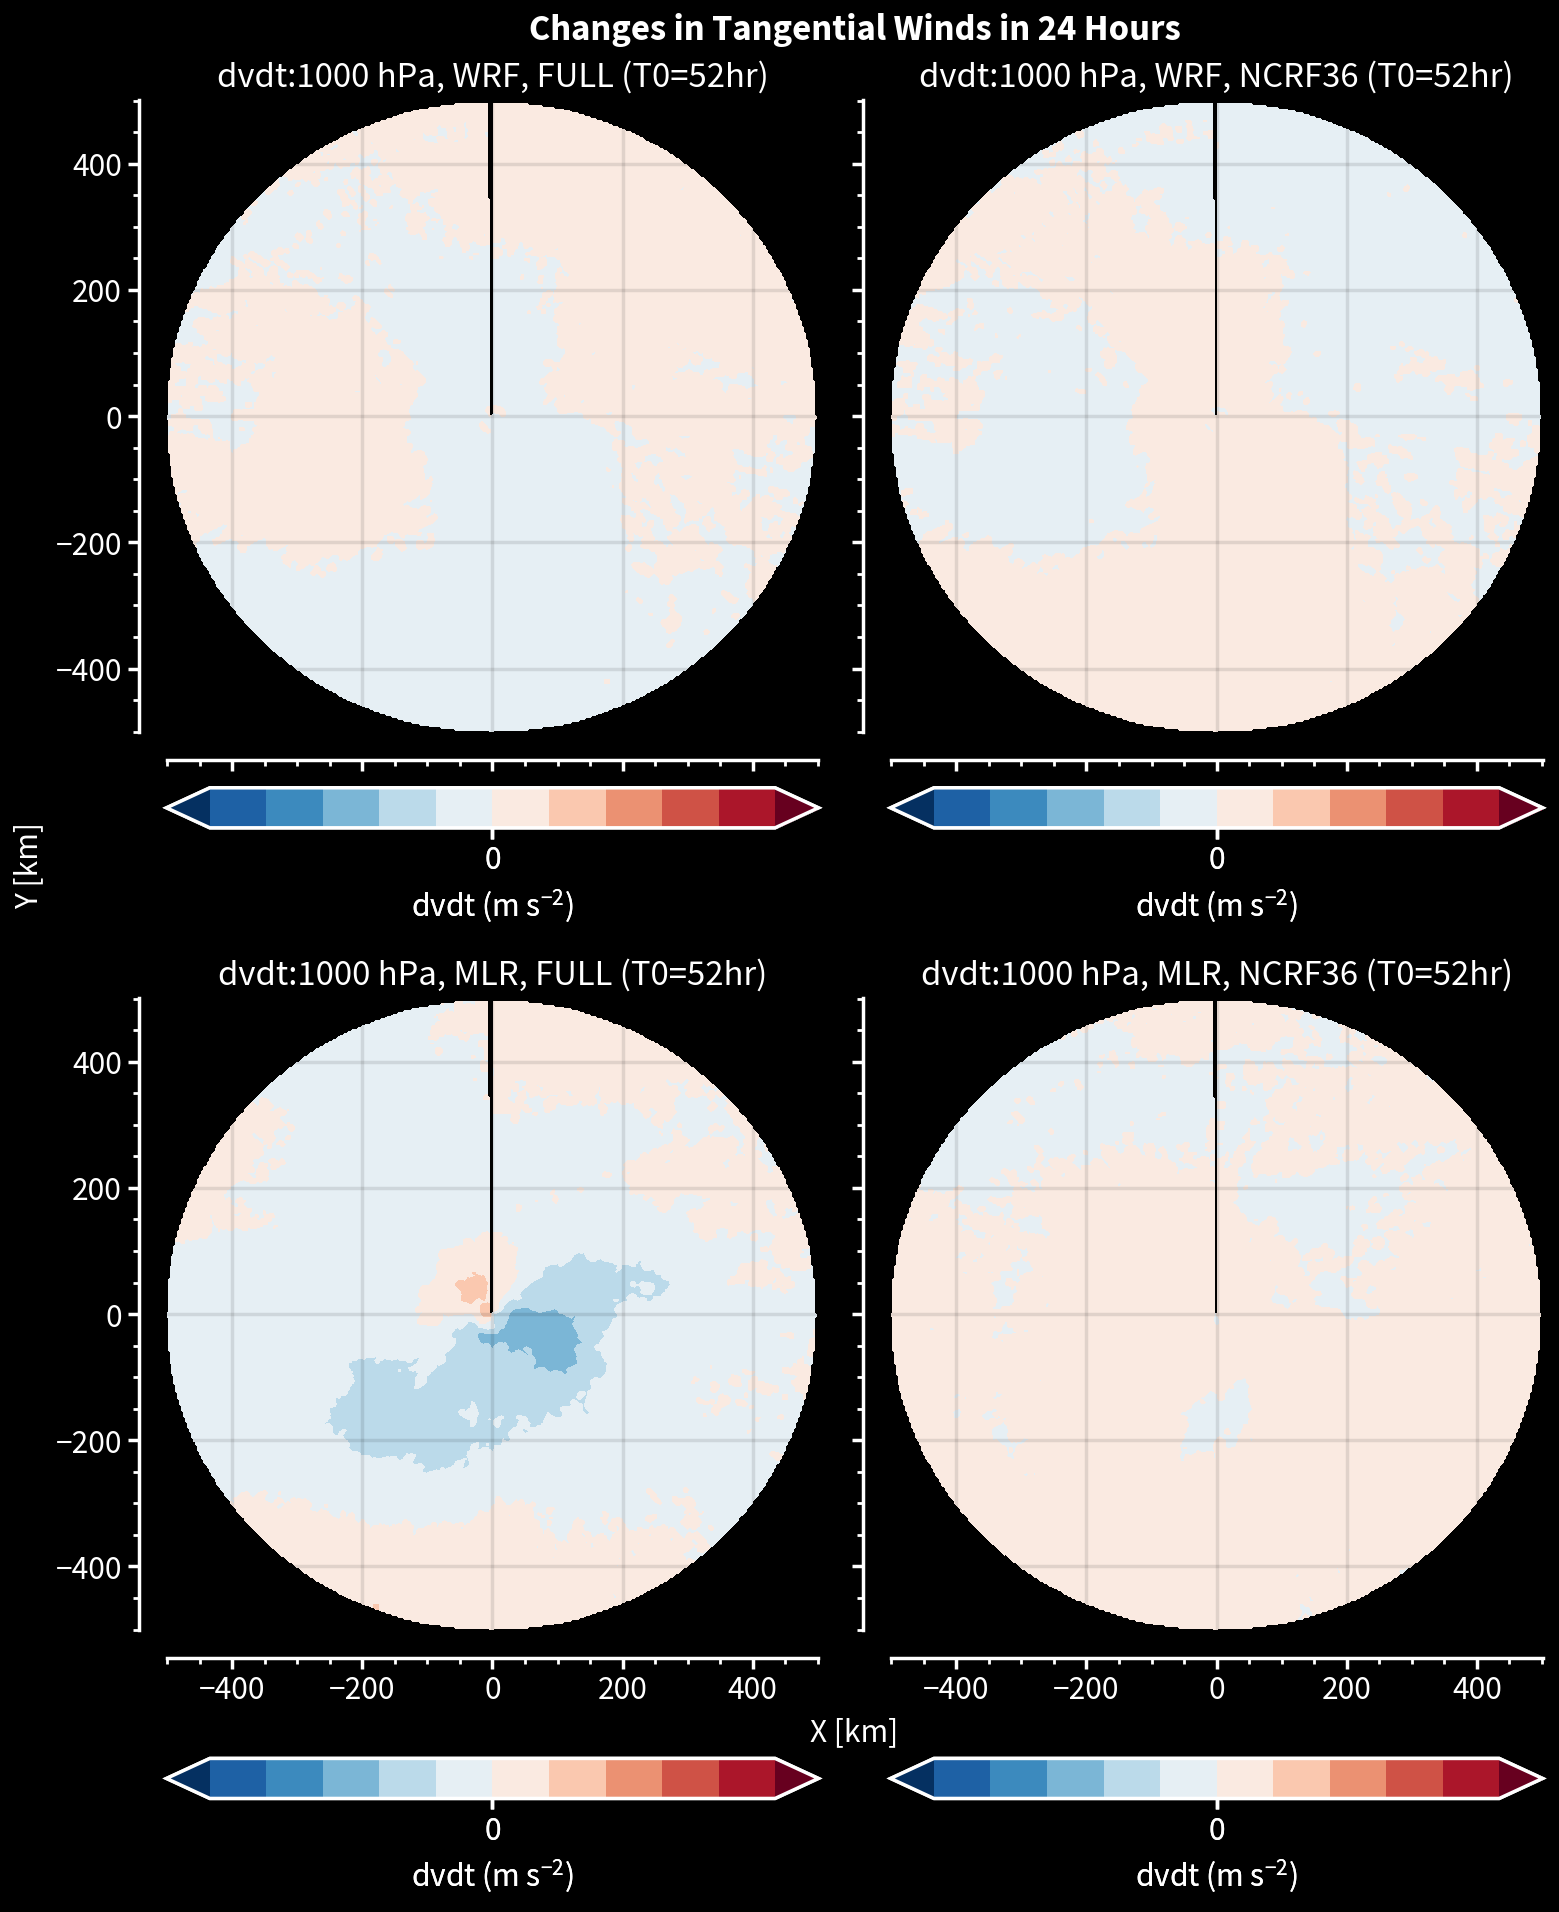

In [55]:
from tools import plotting
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','suptitle.color':'w','title.color':'w','leftlabel.color':'w','fontname': 'Source Sans Pro', 'fontsize': 12,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'
ANGLE = azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-np.linspace(0,167,168)*3),np.linspace(0,167,168)*3))

smpl = 406
y = [ np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_rad6).reshape(dvdt_rad6.shape[0],39,360,167))[10+14+6,0,...],ANGLE,True,False)))),\
     np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_rad6).reshape(dvdt_rad6.shape[0],39,360,167))[72+14+6,0,...],ANGLE,True,False)))),\
    np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_rad9).reshape(dvdt_rad9.shape[0],39,360,167))[10+14+6,0,...],ANGLE,True,False)))),\
     np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_rad9).reshape(dvdt_rad9.shape[0],39,360,167))[72+14+6,0,...],ANGLE,True,False))))]

typelabel=['WRF, FULL (T0=52hr)','WRF, NCRF36 (T0=52hr)','MLR, FULL (T0=52hr)','MLR, NCRF36 (T0=52hr)']

fig, axs = plot.subplots(ncols=2,nrows=2,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)',suptitle='Changes in Tangential Winds in 24 Hours')
for indices in range(4):
    axs[indices].contourf(np.linspace(-167,167,334)*3,np.linspace(-167,167,334)*3,np.ma.masked_equal(y[indices],0),\
                            cmap='BuRd',levels=np.linspace(-5e-5,5e-5,11),colorbar='b',colorbar_kw={'format':'simple','ticks':0.00016,'label':'dvdt (m s$^{-2}$)'},extend='both')
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'dvdt:{1000} hPa, {typelabel[indices]}')
    plotting.adjust_spines(axs[indices],['left','bottom'],10)
#axs[7].set_visible(False)
#plt.savefig('./figures/0505/maria_MLRpredict_52.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

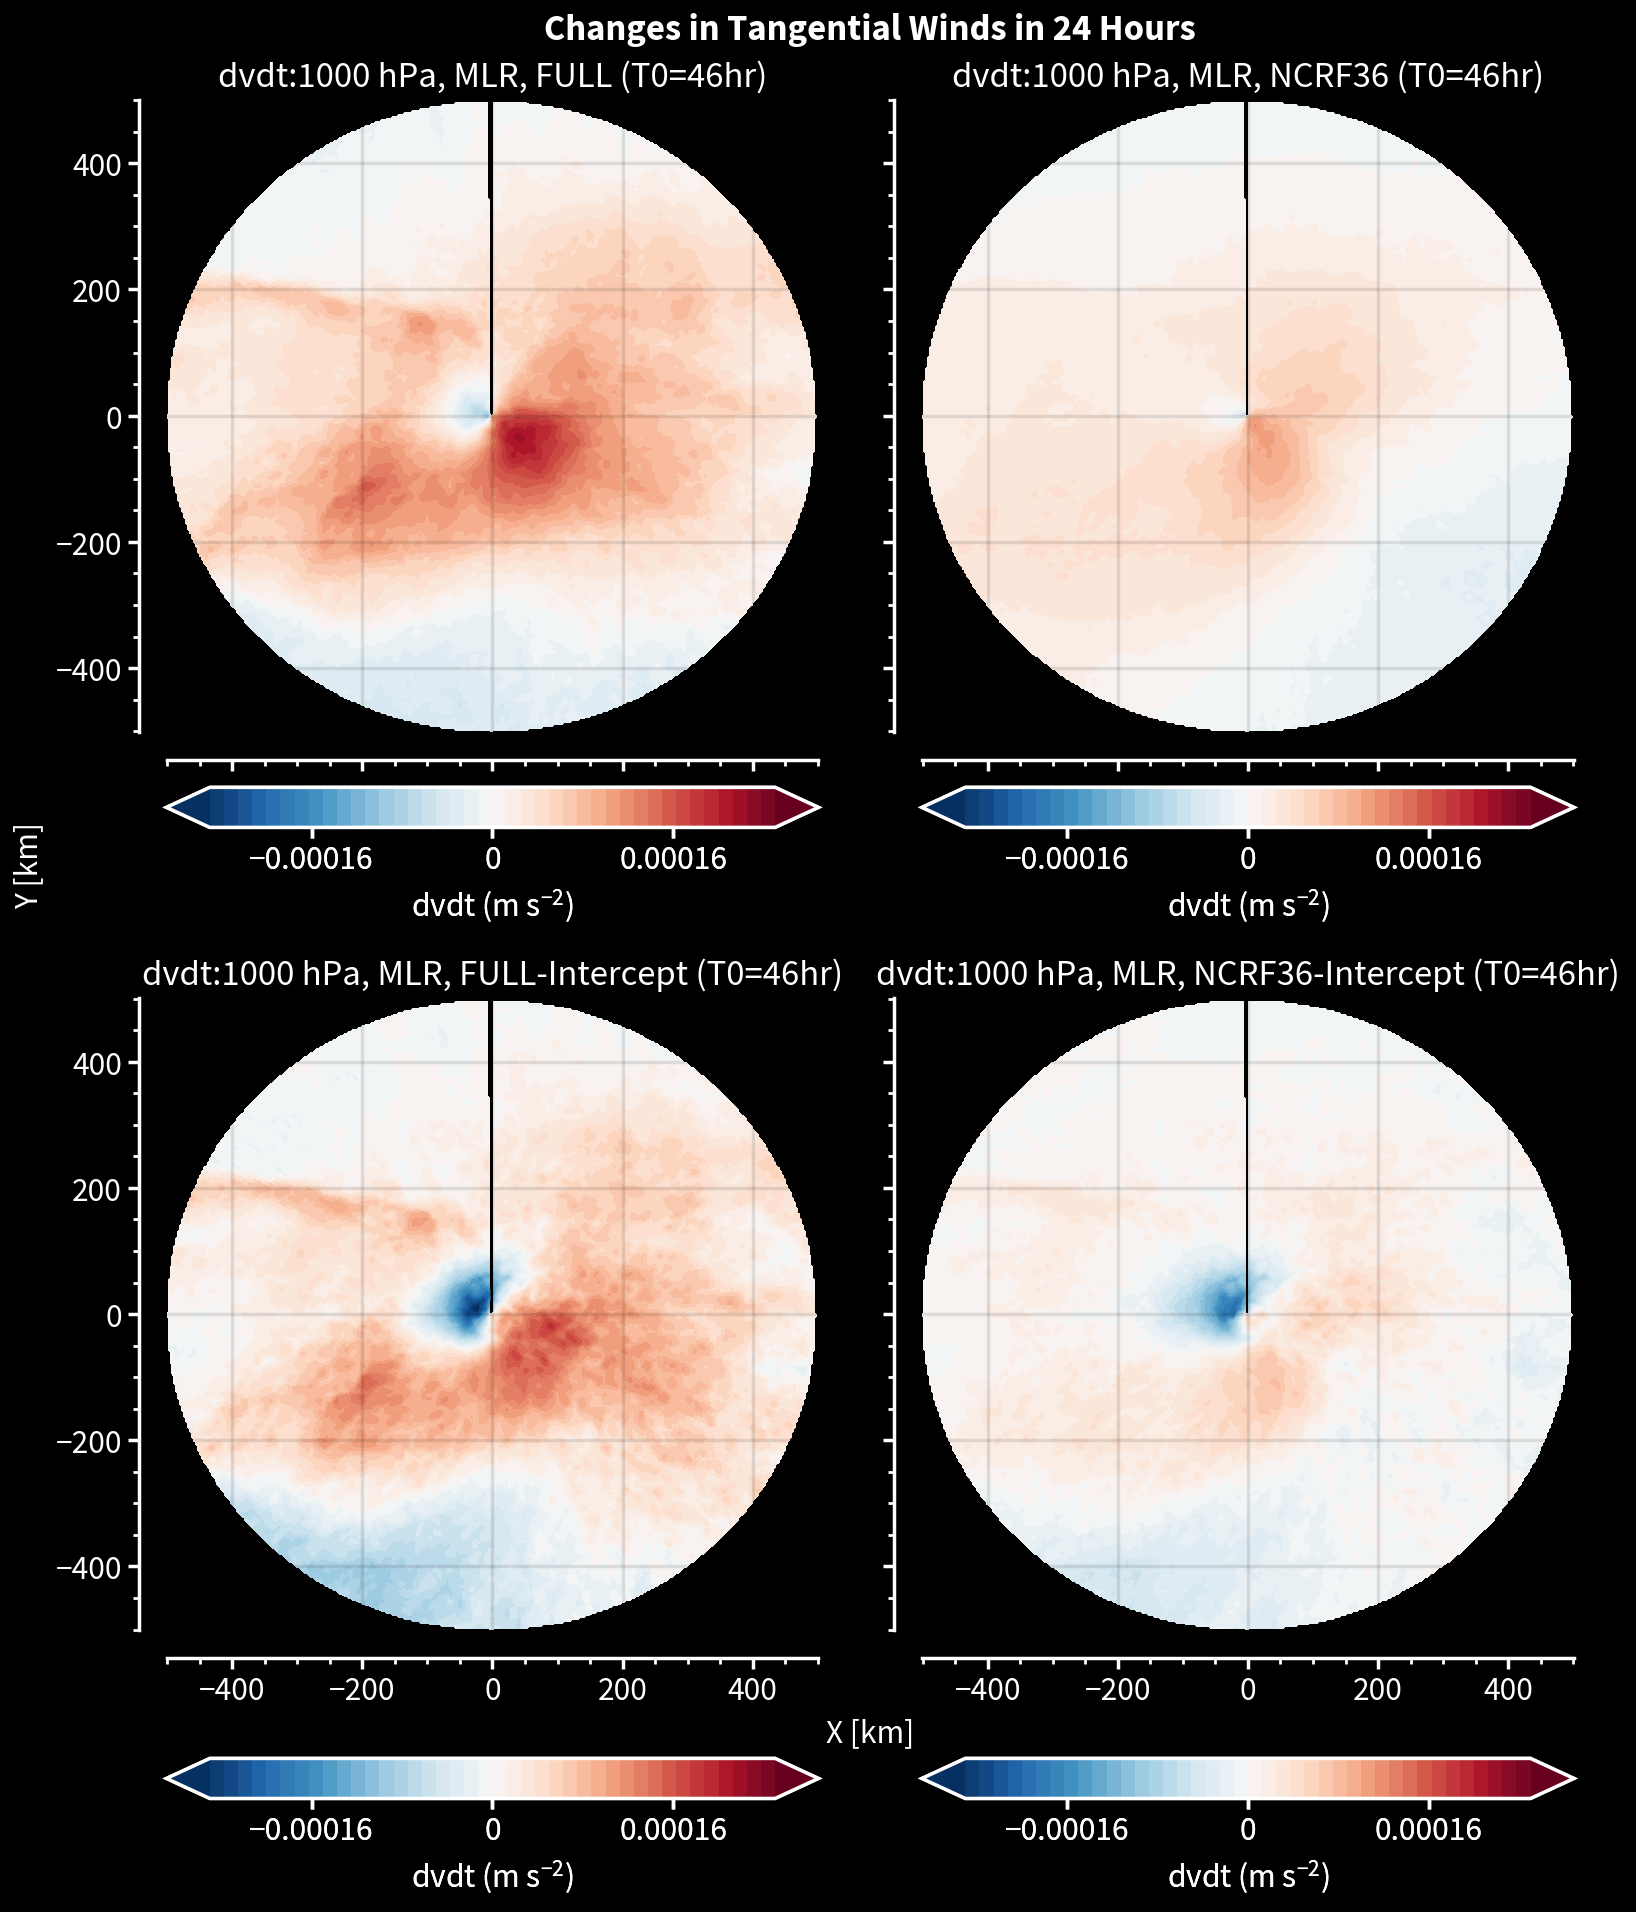

In [23]:
smpl = 406
y = [np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_full).reshape(dvdt_full.shape[0],39,360,167))[10+12,0,...],ANGLE,True,False)))),\
     np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_full).reshape(dvdt_full.shape[0],39,360,167))[72+12,0,...],ANGLE,True,False)))),\
    np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_full-dvdt_b).reshape(dvdt_full.shape[0],39,360,167))[10+12,0,...],ANGLE,True,False)))),\
     np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_full-dvdt_b).reshape(dvdt_full.shape[0],39,360,167))[72+12,0,...],ANGLE,True,False))))]

typelabel=['MLR, FULL (T0=46hr)','MLR, NCRF36 (T0=46hr)','MLR, FULL-Intercept (T0=46hr)','MLR, NCRF36-Intercept (T0=46hr)']

fig, axs = plot.subplots(ncols=2,nrows=2,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)',suptitle='Changes in Tangential Winds in 24 Hours')
for indices in range(4):
    axs[indices].contourf(np.linspace(-167,167,334)*3,np.linspace(-167,167,334)*3,np.ma.masked_equal(y[indices],0),\
                            cmap='BuRd',levels=np.linspace(-25e-5,25e-5,41),colorbar='b',colorbar_kw={'format':'simple','ticks':0.00016,'label':'dvdt (m s$^{-2}$)'},extend='both')
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'dvdt:{1000} hPa, {typelabel[indices]}')
    plotting.adjust_spines(axs[indices],['left','bottom'],10)
#axs[7].set_visible(False)
#plt.savefig('./figures/0505/maria_MLRpredict_46.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()

In [63]:
def make_mask(array=None):
    mask = np.ma.masked_where(np.abs(array)>np.abs(np.sqrt(y[0]**2+yu[0]**2)-np.sqrt(y[1]**2+yu[1]**2)),array).mask
    xindx,yindx = [],[]
    for j, k in zip(*np.where(mask)):
        temp = np.linspace(-167,167,334)*3
        xindx.append(temp[j])
        yindx.append(temp[k])
    return xindx,yindx

maskloc = [make_mask(array=y[i]) for i in range(6)]

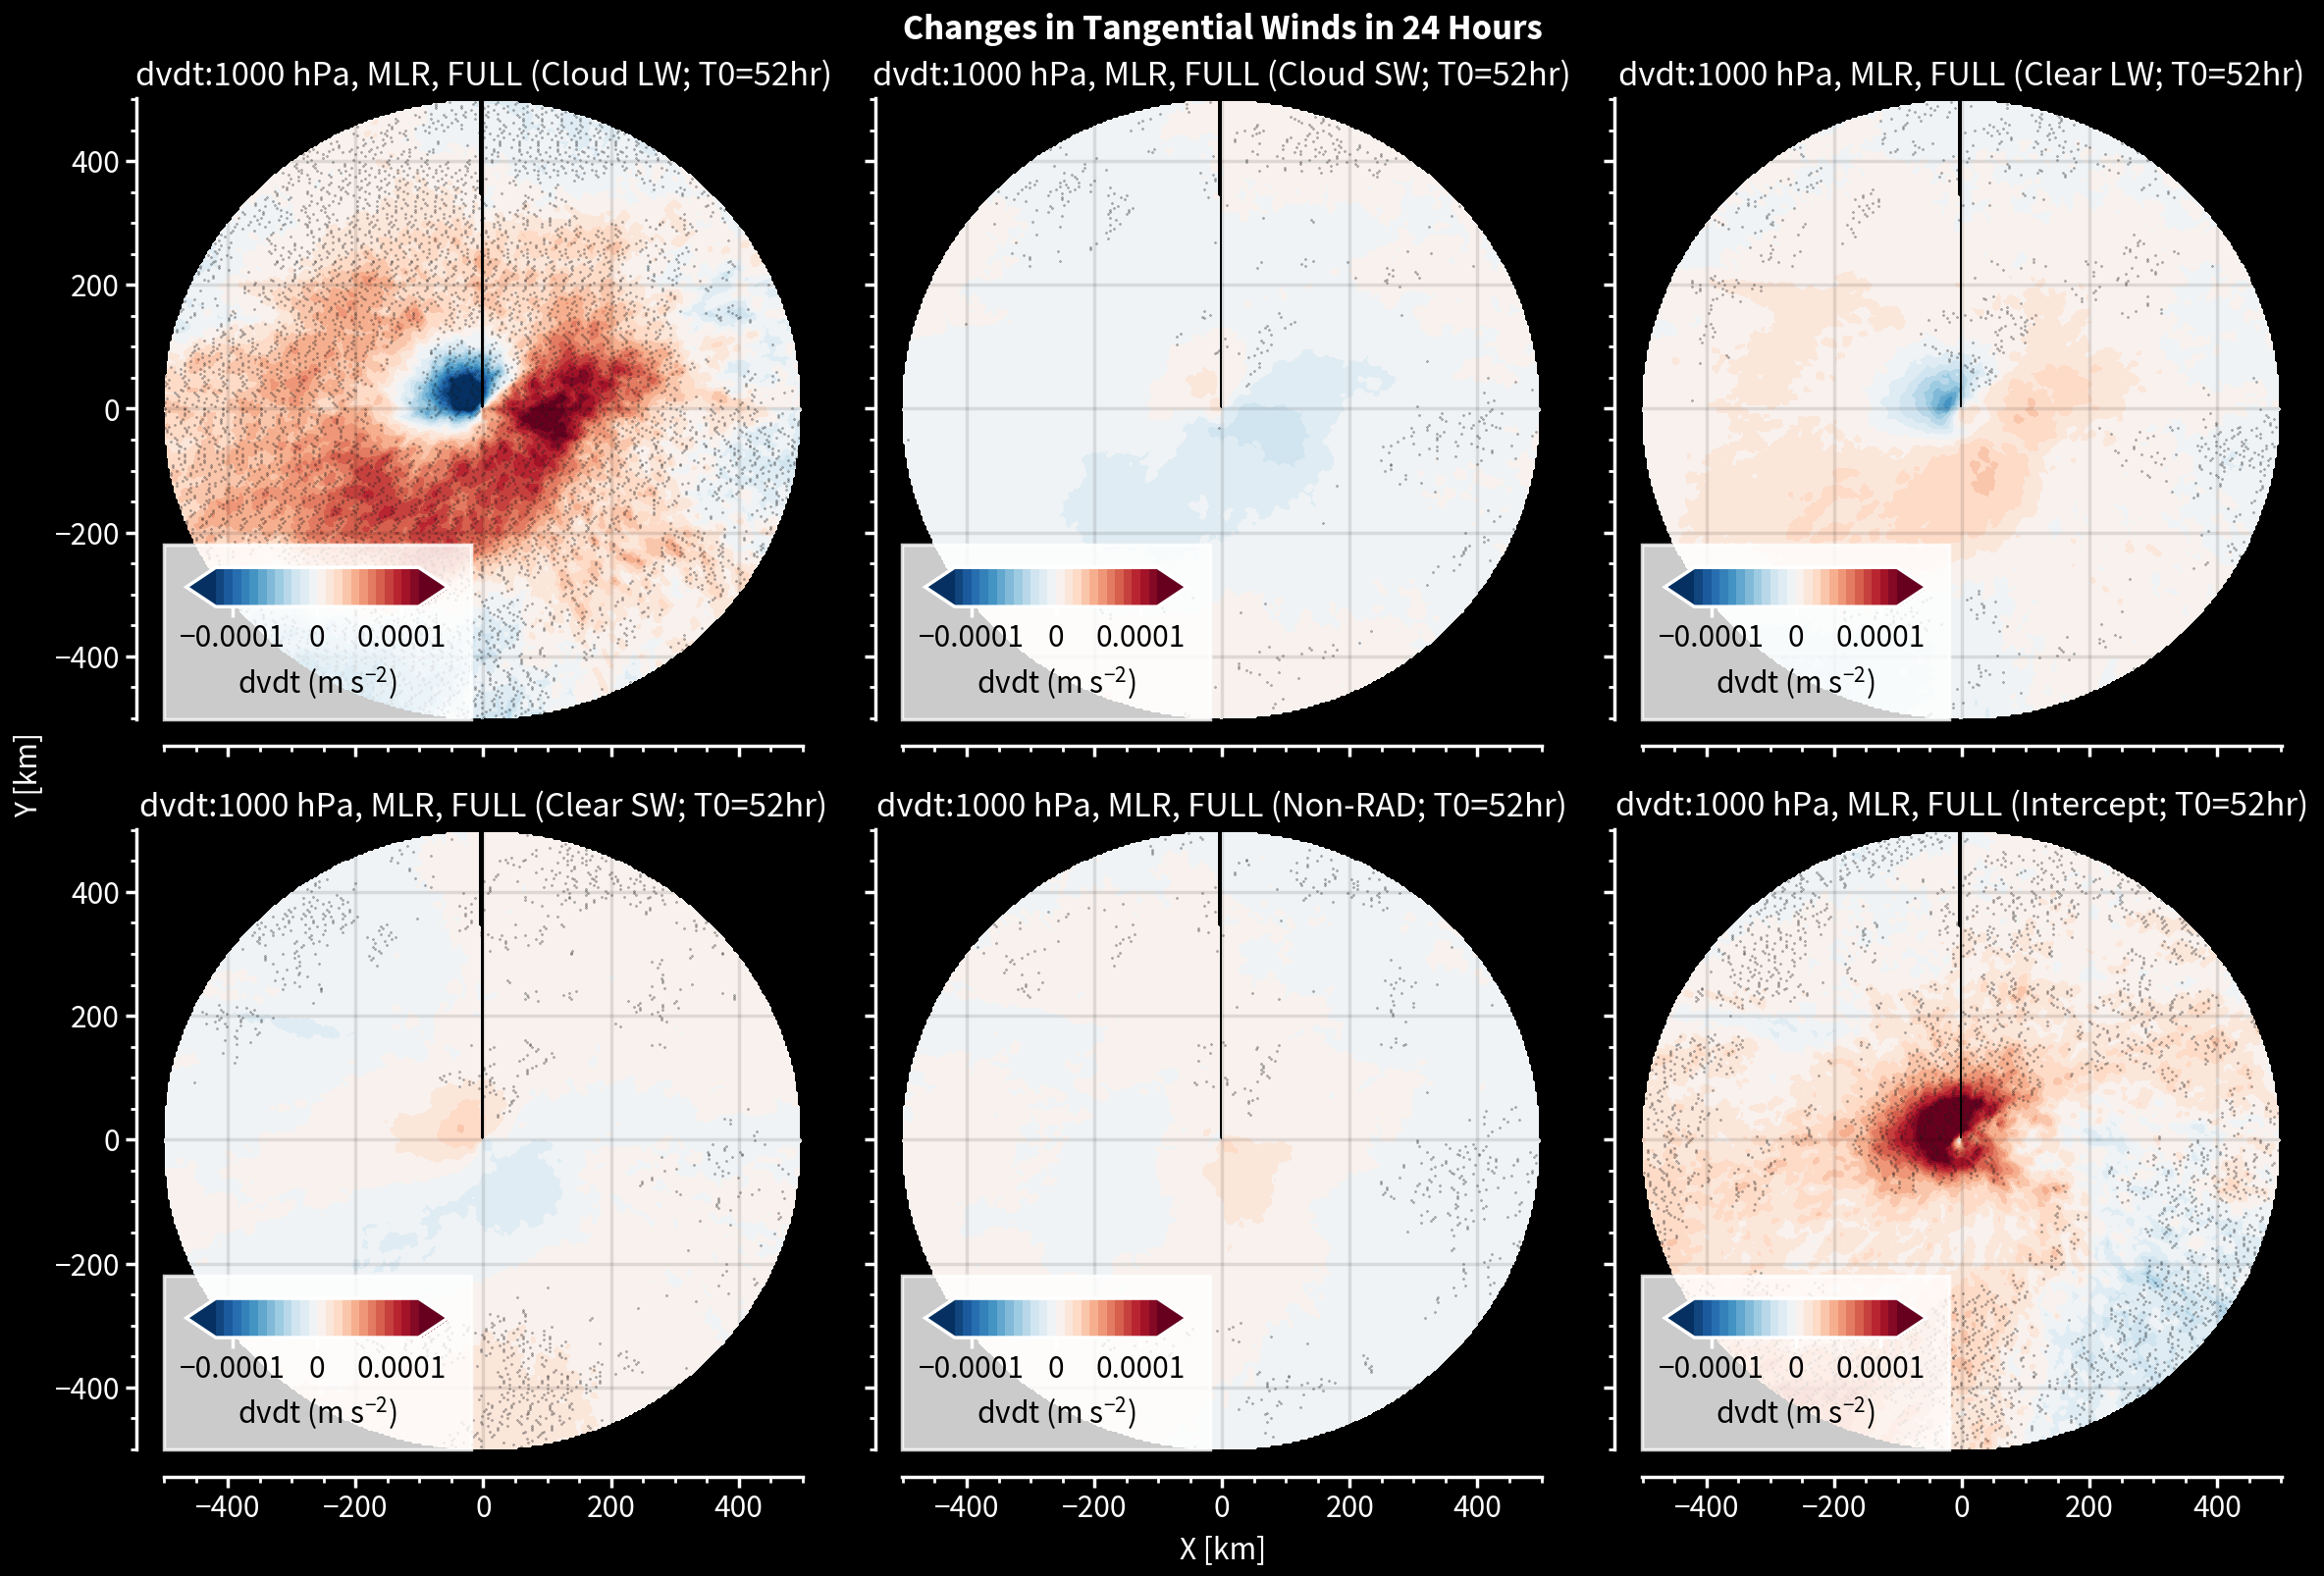

In [66]:
vertlv = 0
y = [ np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_irlw).reshape(dvdt_full.shape[0],39,360,167))[10+14+6,vertlv,...],ANGLE,True,False)))),\
     np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_irsw).reshape(dvdt_full.shape[0],39,360,167))[10+14+6,vertlv,...],ANGLE,True,False)))),\
     np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_lwc).reshape(dvdt_full.shape[0],39,360,167))[10+14+6,vertlv,...],ANGLE,True,False)))),\
     np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_swc).reshape(dvdt_full.shape[0],39,360,167))[10+14+6,vertlv,...],ANGLE,True,False)))),\
    np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_extra).reshape(dvdt_full.shape[0],39,360,167))[10+14+6,vertlv,...],ANGLE,True,False)))),\
    np.fliplr(np.flipud((read_and_proc.proc_tocart(((dvdt_b).reshape(dvdt_full.shape[0],39,360,167))[10+14+6,vertlv,...],ANGLE,True,False))))]

typelabel=['MLR, FULL (Cloud LW; T0=52hr)','MLR, FULL (Cloud SW; T0=52hr)','MLR, FULL (Clear LW; T0=52hr)','MLR, FULL (Clear SW; T0=52hr)','MLR, FULL (Non-RAD; T0=52hr)','MLR, FULL (Intercept; T0=52hr)']

fig, axs = plot.subplots(ncols=3,nrows=2,axwidth=3.2595,refaspect=1.031)
axs.format(titleabove=True,ylabel='Y [km]', xlabel='X (km)',suptitle='Changes in Tangential Winds in 24 Hours')
for indices in range(6):
    axs[indices].contourf(np.linspace(-167,167,334)*3,np.linspace(-167,167,334)*3,np.ma.masked_equal(y[indices],0),\
                            cmap='BuRd',levels=np.linspace(-12e-5,12e-5,25),colorbar='ll',colorbar_kw={'format':'simple','ticks':0.0001,'label':'dvdt (m s$^{-2}$)','facecolor':'k','ticklabelcolor':'k','labelcolor':'k'},extend='both')
    axs[indices].scatter(maskloc[indices][1][::10],maskloc[indices][0][::10],s=0.5,alpha=0.36,marker='o',linewidths=0.2,edgecolors='k',c='gray8')
    axs[indices].format(ylabel='Y [km]',xlabel='X [km]',title=f'dvdt:{1000} hPa, {typelabel[indices]}')
    plotting.adjust_spines(axs[indices],['left','bottom'],10)
#axs[7].set_visible(False)
plt.savefig('./figures/0505/maria_MLRpredict_decomp_52_masked2b.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()